# 🏀 NBA Team Points Prediction Model
🔬 **Feature Engineering**
---    
🙋 **authors**: szymond44, gwiazdan  
📆 **date**: 21-07-2025  


In [140]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.cluster import KMeans
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
%load_ext autoreload
%autoreload 2
from data import DataPreparation
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
dp = DataPreparation(endpoint="mixed",starting_year=2019, ending_year=2025)

In [142]:
train_df, val_df, test_df = dp.dfs

In [143]:
train_df['date'] = pd.to_datetime(train_df['date'])
print(train_df['date'])

0      2019-10-22
1      2019-10-22
2      2019-10-23
3      2019-10-23
4      2019-10-23
          ...    
4932   2023-12-11
4933   2023-12-12
4934   2023-12-12
4935   2023-12-12
4936   2023-12-12
Name: date, Length: 4937, dtype: datetime64[ns]


In [144]:
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['weekday'] = train_df['date'].dt.dayofweek  # 0=monday, 6=sunday

print(train_df['month'].unique())
print(train_df['day'].unique())
print(train_df['weekday'].unique())

[10 11 12  1  2  3  7  8  4  5]
[22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20 21]
[1 2 3 4 5 6 0]


# Month Feature

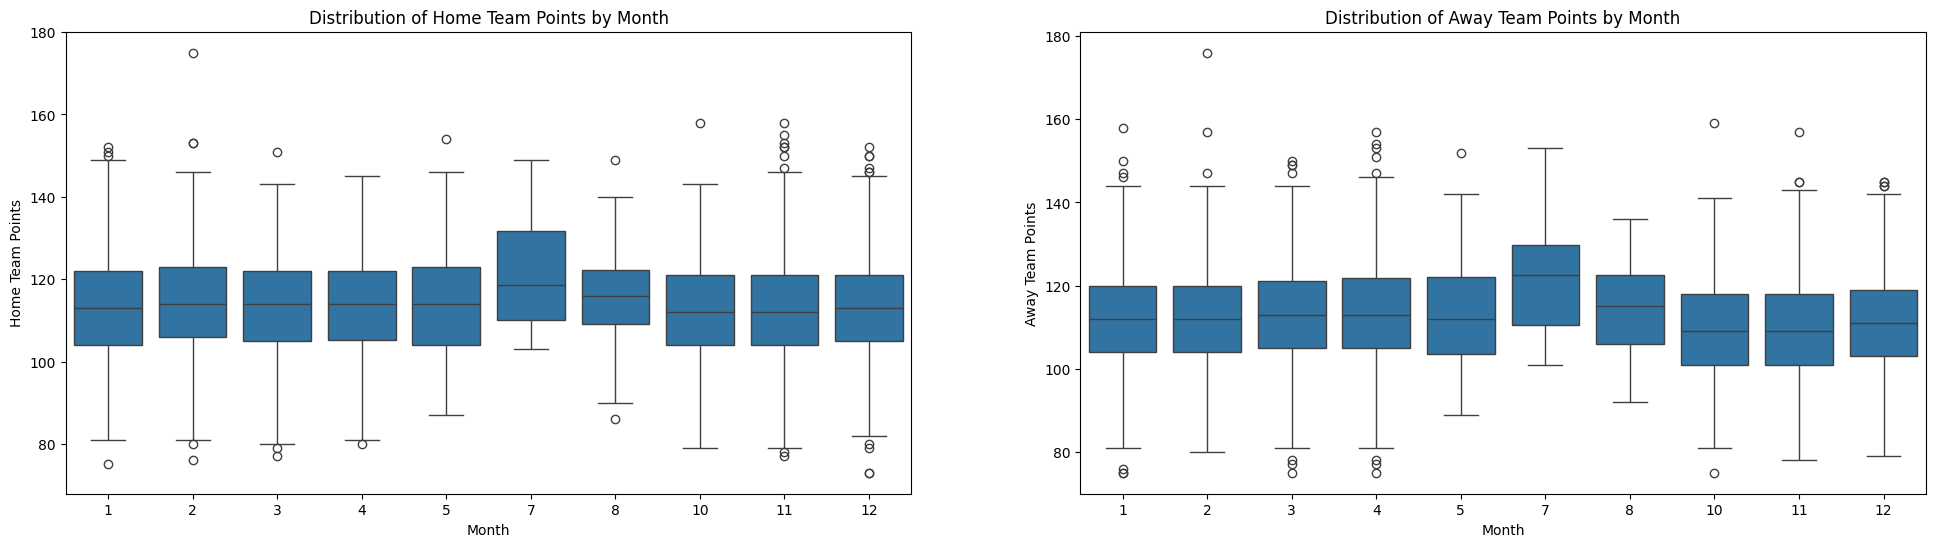

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))
sns.boxplot(x='month', y='home_pts', data=train_df, ax=ax[0])
ax[0].set_title('Distribution of Home Team Points by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Home Team Points')
sns.boxplot(x='month', y='away_pts', data=train_df, ax=ax[1])
ax[1].set_title('Distribution of Away Team Points by Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Away Team Points')
plt.show();

In [146]:
home_pts_mean = {month: train_df[train_df['month'] == month]['home_pts'].mean() for month in range(1, 13)}
away_pts_mean = {month: train_df[train_df['month'] == month]['away_pts'].mean() for month in range(1, 13)}
home_pts_median = {month: train_df[train_df['month'] == month]['home_pts'].median() for month in range(1, 13)}
away_pts_median = {month: train_df[train_df['month'] == month]['away_pts'].median() for month in range(1, 13)}
home_pts_std = {month: train_df[train_df['month'] == month]['home_pts'].std() for month in range(1, 13)}
away_pts_std = {month: train_df[train_df['month'] == month]['away_pts'].std() for month in range(1, 13)}

pts_distribution = pd.DataFrame({
    'month': list(range(1, 13)),
    'home_pts_mean': [home_pts_mean[m] for m in range(1, 13)],
    'away_pts_mean': [away_pts_mean[m] for m in range(1, 13)],
    'home_pts_median': [home_pts_median[m] for m in range(1, 13)],
    'away_pts_median': [away_pts_median[m] for m in range(1, 13)],
    'home_pts_std': [home_pts_std[m] for m in range(1, 13)],
    'away_pts_std': [away_pts_std[m] for m in range(1, 13)]
})
pts_distribution.dropna(inplace=True)

print(pts_distribution)

    month  home_pts_mean  away_pts_mean  home_pts_median  away_pts_median  \
0       1     113.192865     111.414716            113.0            112.0   
1       2     114.284703     112.237960            114.0            112.0   
2       3     113.977027     112.883784            114.0            113.0   
3       4     114.212821     113.300000            114.0            113.0   
4       5     114.103704     113.214815            114.0            112.0   
6       7     121.750000     122.500000            118.5            122.5   
7       8     115.975000     114.087500            116.0            115.0   
9      10     111.952681     109.394322            112.0            109.0   
10     11     112.752554     109.767310            112.0            109.0   
11     12     112.984674     110.927203            113.0            111.0   

    home_pts_std  away_pts_std  
0      12.294182     12.369575  
1      12.488280     12.219158  
2      12.318979     12.191526  
3      12.732500    

In [147]:
print(pts_distribution.corr())

                    month  home_pts_mean  away_pts_mean  home_pts_median  \
month            1.000000      -0.082007      -0.160817        -0.156045   
home_pts_mean   -0.082007       1.000000       0.986757         0.967822   
away_pts_mean   -0.160817       0.986757       1.000000         0.962080   
home_pts_median -0.156045       0.967822       0.962080         1.000000   
away_pts_median -0.178739       0.982089       0.987503         0.975557   
home_pts_std     0.017227       0.814366       0.833548         0.665866   
away_pts_std    -0.065730       0.830013       0.863032         0.711839   

                 away_pts_median  home_pts_std  away_pts_std  
month                  -0.178739      0.017227     -0.065730  
home_pts_mean           0.982089      0.814366      0.830013  
away_pts_mean           0.987503      0.833548      0.863032  
home_pts_median         0.975557      0.665866      0.711839  
away_pts_median         1.000000      0.768677      0.805652  
home_pts_std 

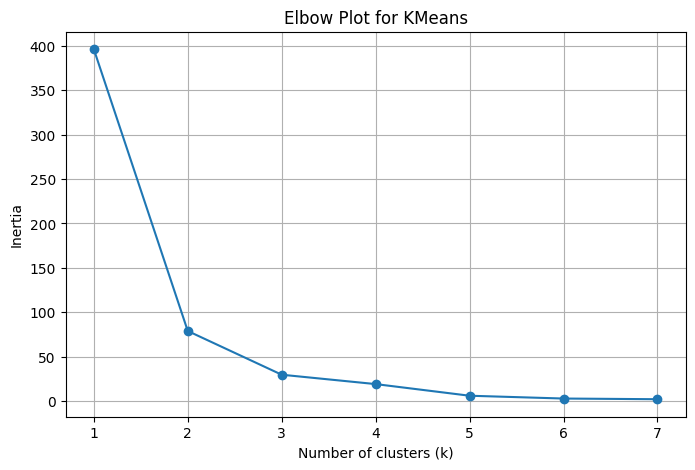

In [148]:
inertia = []
K_range = range(1, 8)
X = pts_distribution[pts_distribution.columns.difference(['month'])].values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show();

In [149]:
X = pts_distribution[['home_pts_mean', 'away_pts_mean']].values

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

pts_distribution['month_group'] = labels

print(pts_distribution)

    month  home_pts_mean  away_pts_mean  home_pts_median  away_pts_median  \
0       1     113.192865     111.414716            113.0            112.0   
1       2     114.284703     112.237960            114.0            112.0   
2       3     113.977027     112.883784            114.0            113.0   
3       4     114.212821     113.300000            114.0            113.0   
4       5     114.103704     113.214815            114.0            112.0   
6       7     121.750000     122.500000            118.5            122.5   
7       8     115.975000     114.087500            116.0            115.0   
9      10     111.952681     109.394322            112.0            109.0   
10     11     112.752554     109.767310            112.0            109.0   
11     12     112.984674     110.927203            113.0            111.0   

    home_pts_std  away_pts_std  month_group  
0      12.294182     12.369575            2  
1      12.488280     12.219158            0  
2      12.3189

<Axes: xlabel='home_pts_mean', ylabel='away_pts_mean'>

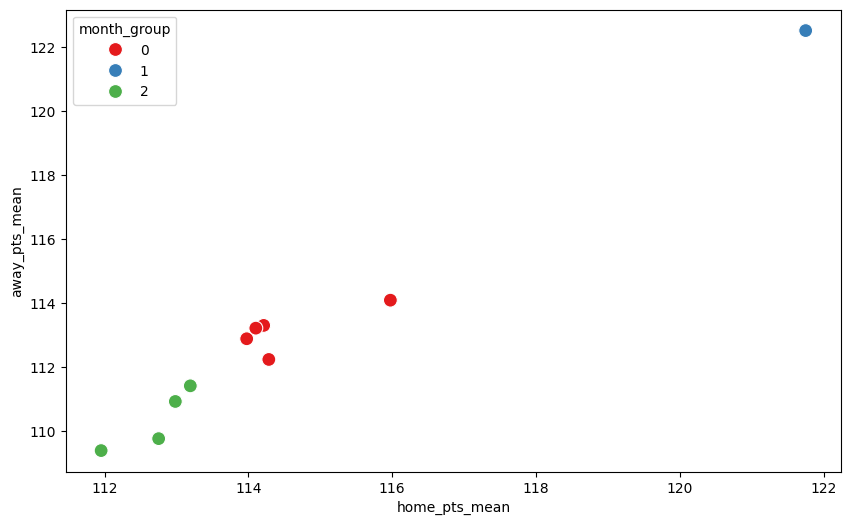

In [150]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='home_pts_mean', y='away_pts_mean', hue='month_group', data=pts_distribution, palette='Set1', s=100)

In [151]:
print(pts_distribution.corr())

                    month  home_pts_mean  away_pts_mean  home_pts_median  \
month            1.000000      -0.082007      -0.160817        -0.156045   
home_pts_mean   -0.082007       1.000000       0.986757         0.967822   
away_pts_mean   -0.160817       0.986757       1.000000         0.962080   
home_pts_median -0.156045       0.967822       0.962080         1.000000   
away_pts_median -0.178739       0.982089       0.987503         0.975557   
home_pts_std     0.017227       0.814366       0.833548         0.665866   
away_pts_std    -0.065730       0.830013       0.863032         0.711839   
month_group      0.525808      -0.288935      -0.340762        -0.455513   

                 away_pts_median  home_pts_std  away_pts_std  month_group  
month                  -0.178739      0.017227     -0.065730     0.525808  
home_pts_mean           0.982089      0.814366      0.830013    -0.288935  
away_pts_mean           0.987503      0.833548      0.863032    -0.340762  
home_pts_me

# Day Feature

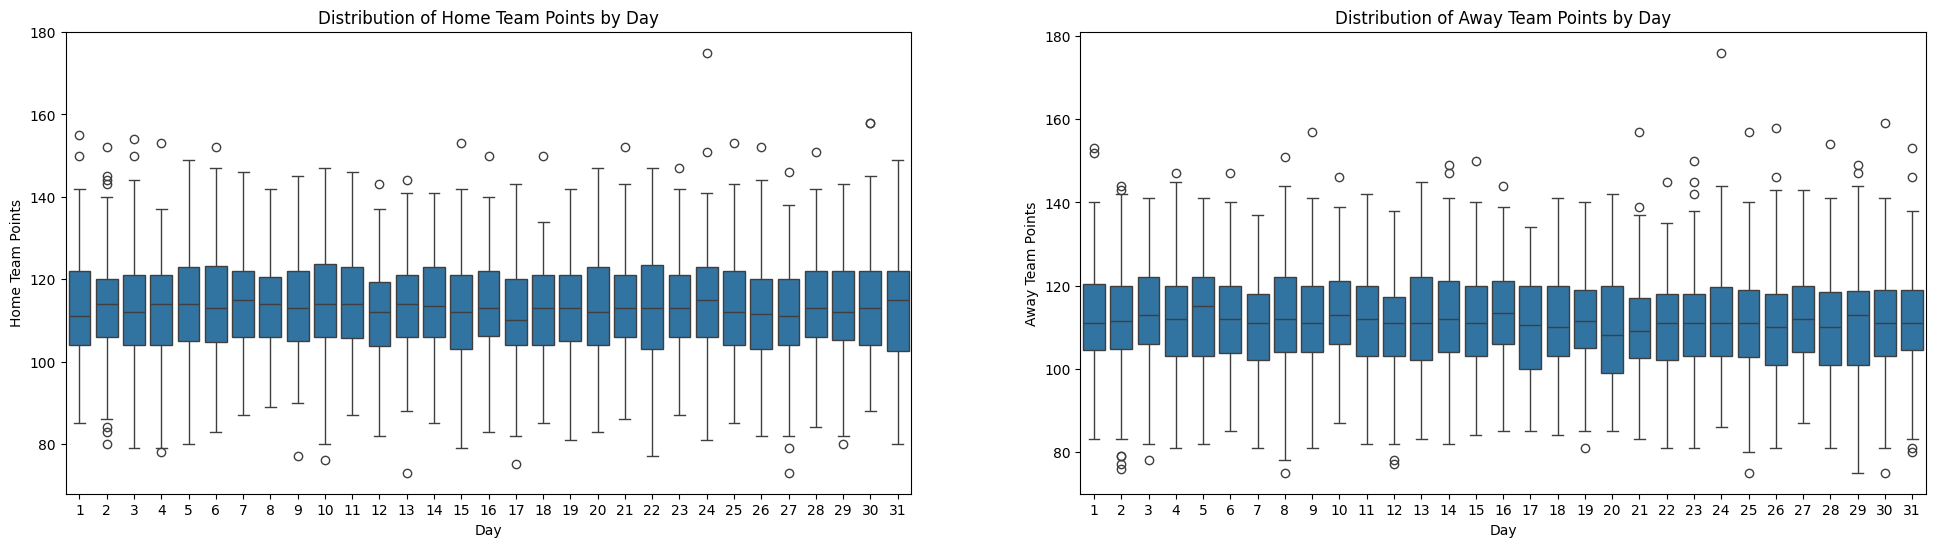

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))
sns.boxplot(x='day', y='home_pts', data=train_df, ax=ax[0])
ax[0].set_title('Distribution of Home Team Points by Day')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Home Team Points')
sns.boxplot(x='day', y='away_pts', data=train_df, ax=ax[1])
ax[1].set_title('Distribution of Away Team Points by Day')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Away Team Points')
plt.show();

In [153]:
home_pts_mean = {day: train_df[train_df['day'] == day]['home_pts'].mean() for day in range(1, 32)}
away_pts_mean = {day: train_df[train_df['day'] == day]['away_pts'].mean() for day in range(1, 32)}
home_pts_median = {day: train_df[train_df['day'] == day]['home_pts'].median() for day in range(1, 32)}
away_pts_median = {day: train_df[train_df['day'] == day]['away_pts'].median() for day in range(1, 32)}
home_pts_std = {day: train_df[train_df['day'] == day]['home_pts'].std() for day in range(1, 32)}
away_pts_std = {day: train_df[train_df['day'] == day]['away_pts'].std() for day in range(1, 32)}

pts_distribution = pd.DataFrame({
    'day': list(range(1, 32)),
    'home_pts_mean': [home_pts_mean[m] for m in range(1, 32)],
    'away_pts_mean': [away_pts_mean[m] for m in range(1, 32)],
    'home_pts_median': [home_pts_median[m] for m in range(1, 32)],
    'away_pts_median': [away_pts_median[m] for m in range(1, 32)],
    'home_pts_std': [home_pts_std[m] for m in range(1, 32)],
    'away_pts_std': [away_pts_std[m] for m in range(1, 32)]
})
pts_distribution.dropna(inplace=True)

print(pts_distribution)

    day  home_pts_mean  away_pts_mean  home_pts_median  away_pts_median  \
0     1     112.608939     112.189944            111.0            111.0   
1     2     113.744681     111.585106            114.0            111.5   
2     3     113.217877     113.256983            112.0            113.0   
3     4     112.771277     112.074468            114.0            112.0   
4     5     114.110429     112.705521            114.0            115.0   
5     6     114.313830     111.792553            113.0            112.0   
6     7     114.617284     110.475309            115.0            111.0   
7     8     113.958974     112.041026            114.0            112.0   
8     9     113.173913     112.049689            113.0            111.0   
9    10     114.511494     112.821839            114.0            113.0   
10   11     114.392045     111.505682            114.0            112.0   
11   12     111.512500     110.006250            112.0            111.0   
12   13     114.035211   

In [154]:
print(pts_distribution.corr())

                      day  home_pts_mean  away_pts_mean  home_pts_median  \
day              1.000000      -0.139655      -0.420997        -0.150564   
home_pts_mean   -0.139655       1.000000       0.396521         0.751638   
away_pts_mean   -0.420997       0.396521       1.000000         0.271906   
home_pts_median -0.150564       0.751638       0.271906         1.000000   
away_pts_median -0.369271       0.219763       0.722591         0.213102   
home_pts_std     0.004824       0.032003       0.059573        -0.013223   
away_pts_std     0.064496       0.183043      -0.085883         0.174913   

                 away_pts_median  home_pts_std  away_pts_std  
day                    -0.369271      0.004824      0.064496  
home_pts_mean           0.219763      0.032003      0.183043  
away_pts_mean           0.722591      0.059573     -0.085883  
home_pts_median         0.213102     -0.013223      0.174913  
away_pts_median         1.000000      0.054511      0.006187  
home_pts_std 

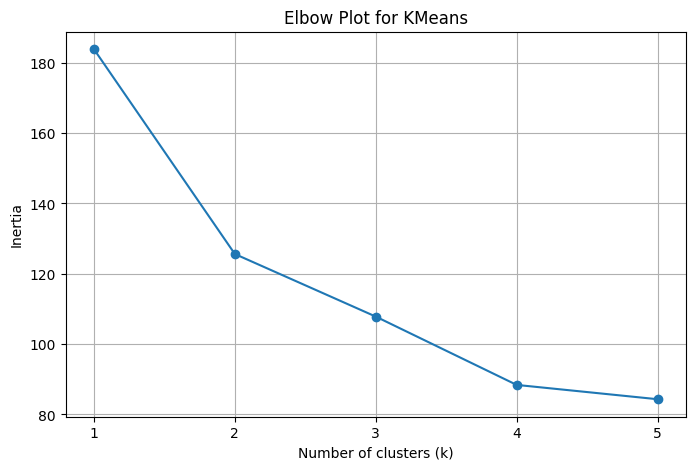

In [155]:
inertia = []
K_range = range(1, 6)
X = pts_distribution[pts_distribution.columns.difference(['day'])].values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show();

In [156]:
X = pts_distribution[pts_distribution.columns.difference(['day'])].values

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

pts_distribution['day_group'] = labels

print(pts_distribution)

    day  home_pts_mean  away_pts_mean  home_pts_median  away_pts_median  \
0     1     112.608939     112.189944            111.0            111.0   
1     2     113.744681     111.585106            114.0            111.5   
2     3     113.217877     113.256983            112.0            113.0   
3     4     112.771277     112.074468            114.0            112.0   
4     5     114.110429     112.705521            114.0            115.0   
5     6     114.313830     111.792553            113.0            112.0   
6     7     114.617284     110.475309            115.0            111.0   
7     8     113.958974     112.041026            114.0            112.0   
8     9     113.173913     112.049689            113.0            111.0   
9    10     114.511494     112.821839            114.0            113.0   
10   11     114.392045     111.505682            114.0            112.0   
11   12     111.512500     110.006250            112.0            111.0   
12   13     114.035211   

<Axes: xlabel='home_pts_mean', ylabel='away_pts_mean'>

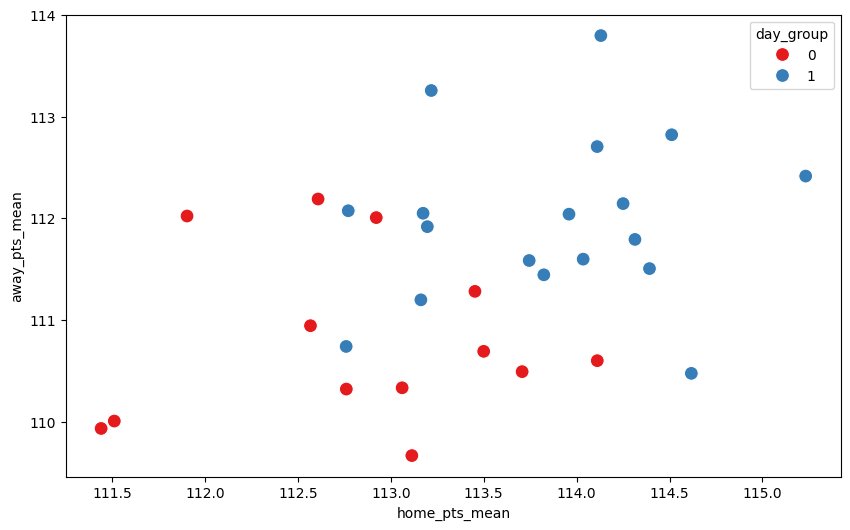

In [157]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='home_pts_mean', y='away_pts_mean', hue='day_group', data=pts_distribution, palette='Set1', s=100)

In [158]:
print(pts_distribution.corr())

                      day  home_pts_mean  away_pts_mean  home_pts_median  \
day              1.000000      -0.139655      -0.420997        -0.150564   
home_pts_mean   -0.139655       1.000000       0.396521         0.751638   
away_pts_mean   -0.420997       0.396521       1.000000         0.271906   
home_pts_median -0.150564       0.751638       0.271906         1.000000   
away_pts_median -0.369271       0.219763       0.722591         0.213102   
home_pts_std     0.004824       0.032003       0.059573        -0.013223   
away_pts_std     0.064496       0.183043      -0.085883         0.174913   
day_group       -0.343514       0.580165       0.582702         0.659387   

                 away_pts_median  home_pts_std  away_pts_std  day_group  
day                    -0.369271      0.004824      0.064496  -0.343514  
home_pts_mean           0.219763      0.032003      0.183043   0.580165  
away_pts_mean           0.722591      0.059573     -0.085883   0.582702  
home_pts_median    

# Weekday Feature

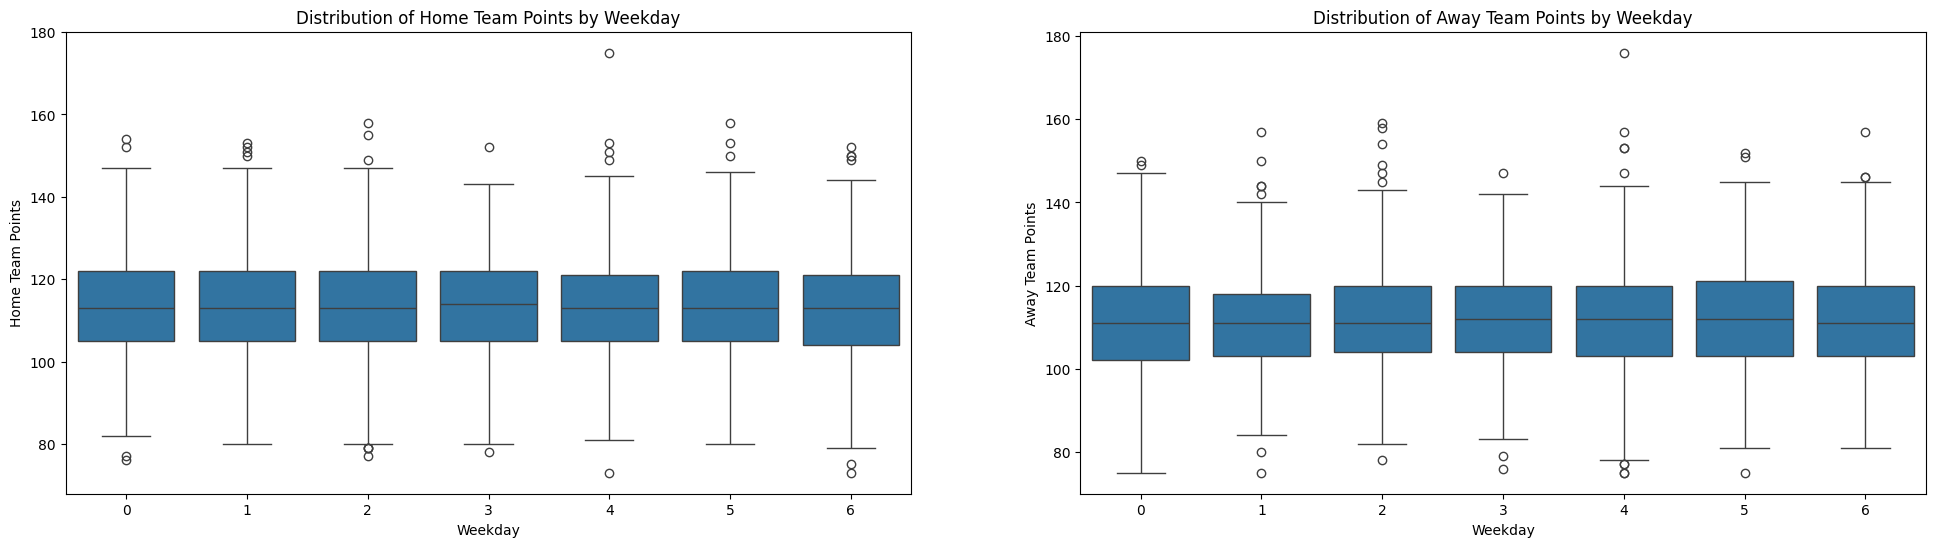

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))
sns.boxplot(x='weekday', y='home_pts', data=train_df, ax=ax[0])
ax[0].set_title('Distribution of Home Team Points by Weekday')
ax[0].set_xlabel('Weekday')
ax[0].set_ylabel('Home Team Points')
sns.boxplot(x='weekday', y='away_pts', data=train_df, ax=ax[1])
ax[1].set_title('Distribution of Away Team Points by Weekday')
ax[1].set_xlabel('Weekday')
ax[1].set_ylabel('Away Team Points')
plt.show();

In [160]:
home_pts_mean = {weekday: train_df[train_df['weekday'] == weekday]['home_pts'].mean() for weekday in range(0, 7)}
away_pts_mean = {weekday: train_df[train_df['weekday'] == weekday]['away_pts'].mean() for weekday in range(0, 7)}
home_pts_median = {weekday: train_df[train_df['weekday'] == weekday]['home_pts'].median() for weekday in range(0, 7)}
away_pts_median = {weekday: train_df[train_df['weekday'] == weekday]['away_pts'].median() for weekday in range(0, 7)}
home_pts_std = {weekday: train_df[train_df['weekday'] == weekday]['home_pts'].std() for weekday in range(0, 7)}
away_pts_std = {weekday: train_df[train_df['weekday'] == weekday]['away_pts'].std() for weekday in range(0, 7)}

pts_distribution = pd.DataFrame({
    'weekday': list(range(0, 7)),
    'home_pts_mean': [home_pts_mean[m] for m in range(0, 7)],
    'away_pts_mean': [away_pts_mean[m] for m in range(0, 7)],
    'home_pts_median': [home_pts_median[m] for m in range(0, 7)],
    'away_pts_median': [away_pts_median[m] for m in range(0, 7)],
    'home_pts_std': [home_pts_std[m] for m in range(0, 7)],
    'away_pts_std': [away_pts_std[m] for m in range(0, 7)]
})
pts_distribution.dropna(inplace=True)

print(pts_distribution)

   weekday  home_pts_mean  away_pts_mean  home_pts_median  away_pts_median  \
0        0     114.024490     111.151020            113.0            111.0   
1        1     113.631776     111.267290            113.0            111.0   
2        2     113.454641     111.540084            113.0            111.0   
3        3     113.609649     111.945175            114.0            112.0   
4        4     113.180291     111.787234            113.0            112.0   
5        5     113.431718     111.610866            113.0            112.0   
6        6     112.878084     111.300435            113.0            111.0   

   home_pts_std  away_pts_std  
0     12.631626     12.686228  
1     12.102903     12.029052  
2     12.306927     12.313207  
3     12.692173     12.254950  
4     12.386796     12.615546  
5     12.262033     12.511047  
6     13.049312     12.356314  


In [161]:
print(pts_distribution.corr())

                      weekday  home_pts_mean  away_pts_mean  home_pts_median  \
weekday          1.000000e+00      -0.875640       0.366271    -1.160311e-14   
home_pts_mean   -8.756395e-01       1.000000      -0.217543     1.836879e-01   
away_pts_mean    3.662705e-01      -0.217543       1.000000     6.519841e-01   
home_pts_median -1.160311e-14       0.183688       0.651984     1.000000e+00   
away_pts_median  4.330127e-01      -0.132768       0.856025     4.714045e-01   
home_pts_std     3.963801e-01      -0.351205      -0.077001     2.770432e-01   
away_pts_std     9.408671e-02       0.078172       0.004584    -2.726626e-01   

                 away_pts_median  home_pts_std  away_pts_std  
weekday                 0.433013      0.396380      0.094087  
home_pts_mean          -0.132768     -0.351205      0.078172  
away_pts_mean           0.856025     -0.077001      0.004584  
home_pts_median         0.471405      0.277043     -0.272663  
away_pts_median         1.000000     -0.1258

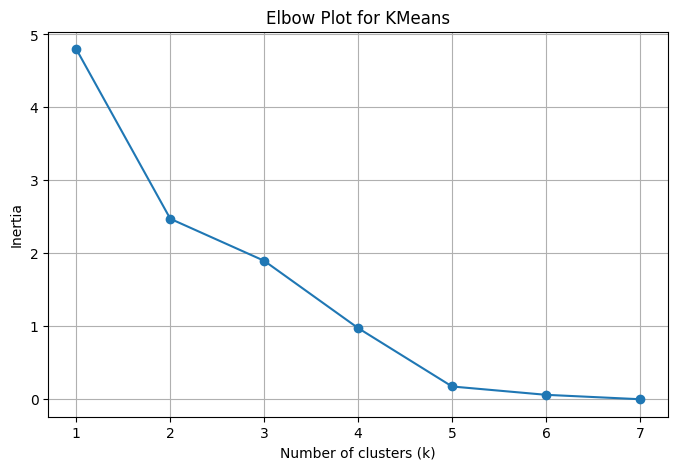

In [162]:
inertia = []
K_range = range(1, 8)
X = pts_distribution[pts_distribution.columns.difference(['weekday'])].values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show();

In [163]:
X = pts_distribution[pts_distribution.columns.difference(['day'])].values

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

pts_distribution['weekday_group'] = labels

print(pts_distribution)

   weekday  home_pts_mean  away_pts_mean  home_pts_median  away_pts_median  \
0        0     114.024490     111.151020            113.0            111.0   
1        1     113.631776     111.267290            113.0            111.0   
2        2     113.454641     111.540084            113.0            111.0   
3        3     113.609649     111.945175            114.0            112.0   
4        4     113.180291     111.787234            113.0            112.0   
5        5     113.431718     111.610866            113.0            112.0   
6        6     112.878084     111.300435            113.0            111.0   

   home_pts_std  away_pts_std  weekday_group  
0     12.631626     12.686228              0  
1     12.102903     12.029052              0  
2     12.306927     12.313207              0  
3     12.692173     12.254950              0  
4     12.386796     12.615546              1  
5     12.262033     12.511047              1  
6     13.049312     12.356314              1  

<Axes: xlabel='home_pts_mean', ylabel='away_pts_mean'>

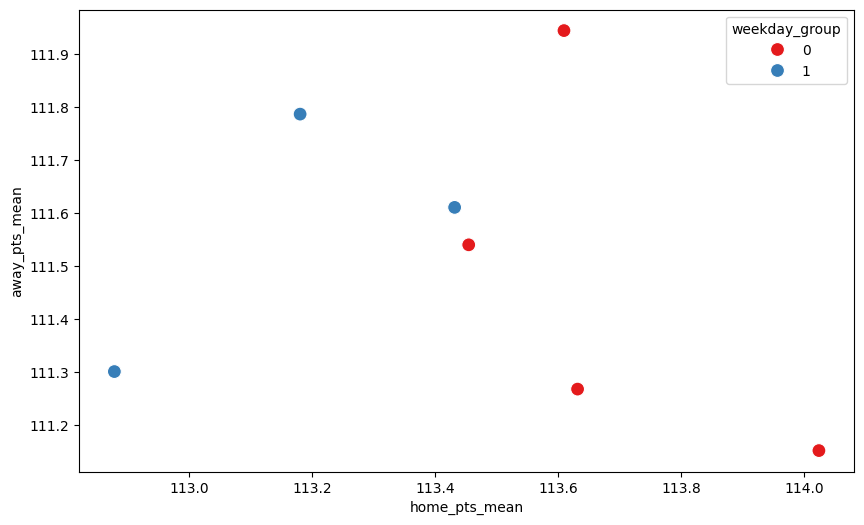

In [164]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='home_pts_mean', y='away_pts_mean', hue='weekday_group', data=pts_distribution, palette='Set1', s=100)

In [165]:
print(pts_distribution.corr())

                      weekday  home_pts_mean  away_pts_mean  home_pts_median  \
weekday          1.000000e+00      -0.875640       0.366271    -1.160311e-14   
home_pts_mean   -8.756395e-01       1.000000      -0.217543     1.836879e-01   
away_pts_mean    3.662705e-01      -0.217543       1.000000     6.519841e-01   
home_pts_median -1.160311e-14       0.183688       0.651984     1.000000e+00   
away_pts_median  4.330127e-01      -0.132768       0.856025     4.714045e-01   
home_pts_std     3.963801e-01      -0.351205      -0.077001     2.770432e-01   
away_pts_std     9.408671e-02       0.078172       0.004584    -2.726626e-01   
weekday_group    8.660254e-01      -0.762108       0.165716    -3.535534e-01   

                 away_pts_median  home_pts_std  away_pts_std  weekday_group  
weekday                 0.433013      0.396380      0.094087       0.866025  
home_pts_mean          -0.132768     -0.351205      0.078172      -0.762108  
away_pts_mean           0.856025     -0.07700

Conclusions:
- Month, Day, and Weekday features have been successfully extracted from the date.
- These features can help capture seasonal and temporal patterns in team performance.
- The unique values for month, day, and weekday have been printed to verify correct extraction.
- These categorical features will be grouped using KMeans clustering to identify patterns in team performance based on the time of the year.